In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
sns.set_theme(context='notebook', style='whitegrid', palette='muted')

In [3]:
from sklearn.preprocessing import StandardScaler

In [4]:
data_dir = Path('../../results')
train = pd.read_csv(data_dir / 'train_clean.csv', index_col=0)

In [5]:
num_cols = train.dtypes[(train.dtypes == 'float64') | (train.dtypes == 'int64')].index
num_cols

Index(['startYear', 'runtimeMinutes', 'numVotes', 'totalImages',
       'totalCredits', 'numRegions', 'companiesNumber', 'averageRating',
       'externalLinks', 'writerCredits', 'numGenres', 'criticReviewsRatio'],
      dtype='object')

In [6]:
scaler = StandardScaler()
train_X = scaler.fit_transform(train[num_cols])

## HBOS

In [7]:
from pyod.models.hbos import HBOS

In [8]:
def sturges_law(N):
    return 1 + math.log(N, 2)

sturges_law(train_X.shape[0])

17.675405775802762

In [9]:
detector = HBOS(n_bins='auto', contamination=0.01)

In [10]:
detector.fit(train_X)

HBOS(alpha=0.1, contamination=0.01, n_bins='auto', tol=0.5)

In [11]:
outliers = detector.predict(train_X)

In [12]:
threshold = detector.decision_scores_[np.where(outliers == 1)].min()

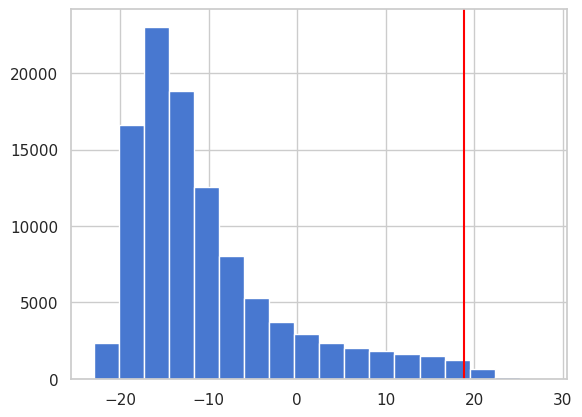

In [13]:
plt.hist(detector.decision_scores_, bins=18)
plt.axvline(threshold, c='red')
plt.show()

In [14]:
train['hbos'] = outliers

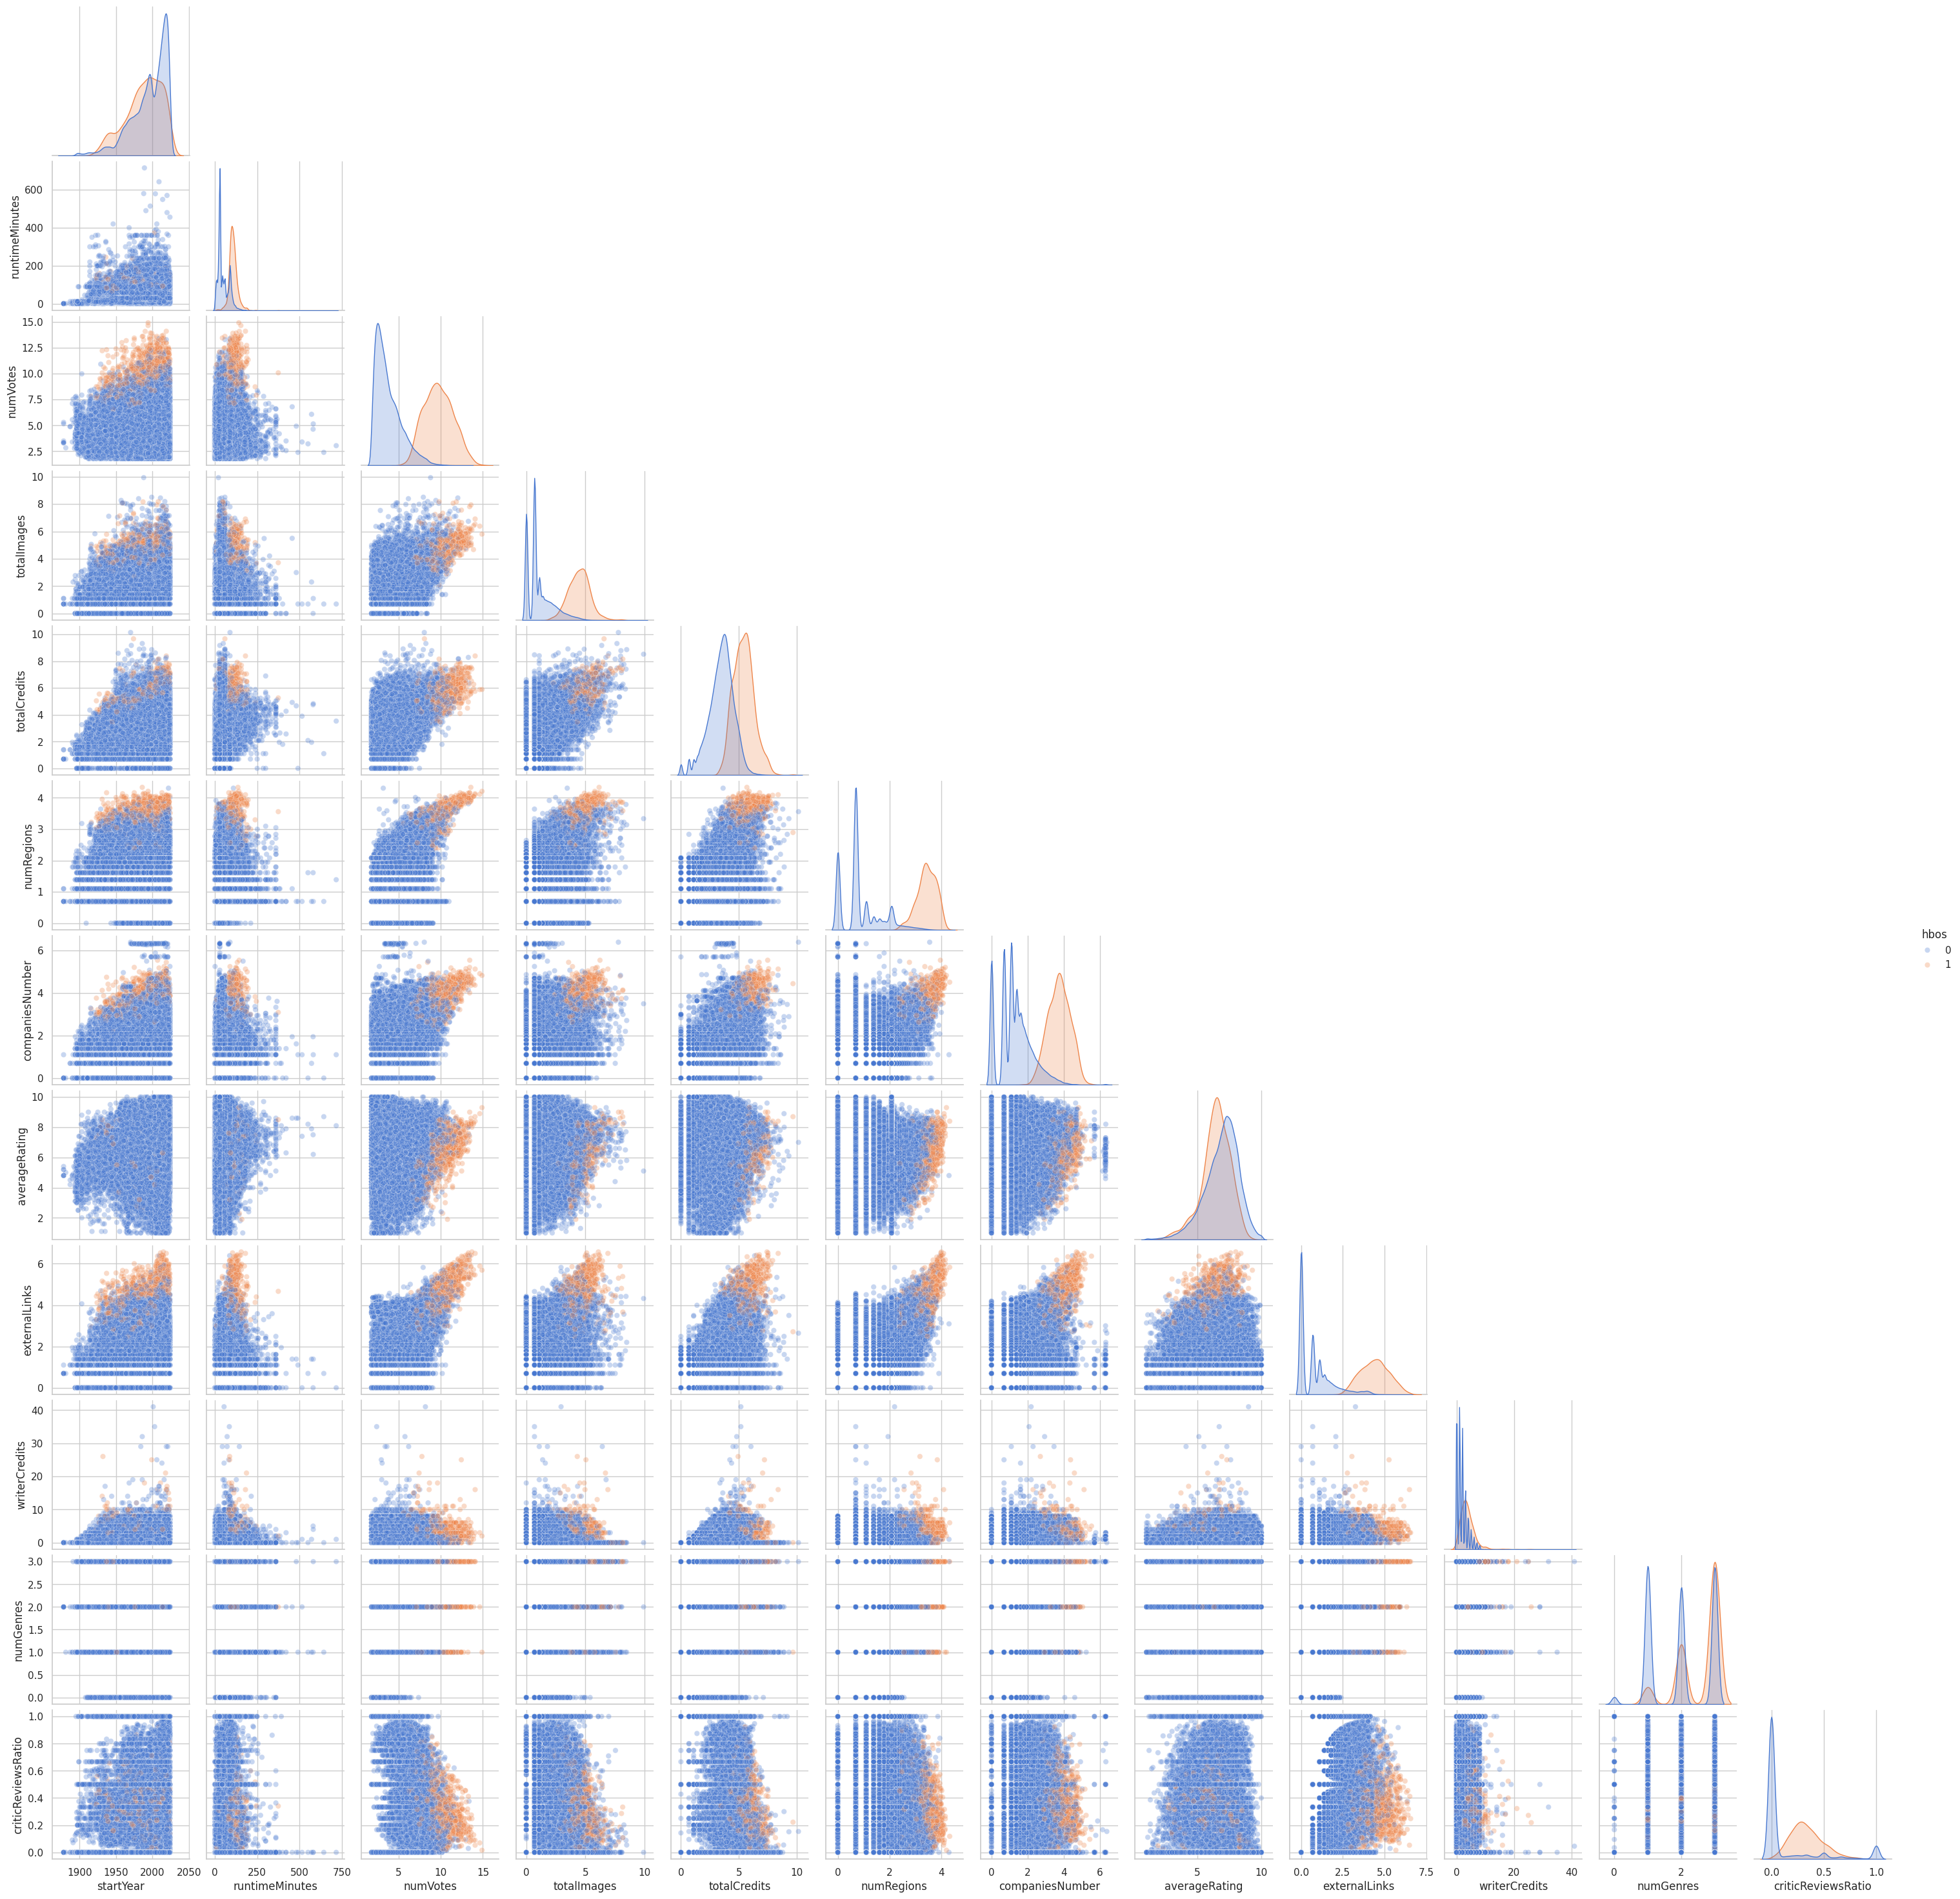

In [15]:
sns.pairplot(train, vars=num_cols, hue='hbos',
             diag_kind='kde', diag_kws=dict(common_norm=False),
             plot_kws=dict(alpha=.3), corner=True)

In [16]:
pd.crosstab(train['hbos'], train['hasAwardsOrNominations'])

hasAwardsOrNominations  False  True 
hbos                                
0                       91608  12009
1                         235    812

In [17]:
train[train['hbos'] == 1]['titleType'].value_counts()

titleType
movie           992
tvSeries         29
video            16
tvMovie           6
short             2
tvMiniSeries      1
tvSpecial         1
Name: count, dtype: int64

In [18]:
train[train['hbos'] == 1].sort_values('numVotes', ascending=False).head(20)

originalTitle   rating  startYear  \
15493              The Shawshank Redemption  (9, 10]       1994   
15456                          Pulp Fiction   (8, 9]       1994   
125716                    Avengers: Endgame   (8, 9]       2019   
13746                            Goodfellas   (8, 9]       1990   
16715                     Good Will Hunting   (8, 9]       1997   
21481                       The Sixth Sense   (8, 9]       1999   
96038                          The Revenant   (7, 8]       2015   
86645                             Prisoners   (8, 9]       2013   
25464   Le fabuleux destin d'Amélie Poulain   (8, 9]       2001   
12648                     Full Metal Jacket   (8, 9]       1987   
60114                                Dexter   (8, 9]       2006   
12239                                Aliens   (8, 9]       1986   
16231                                 Fargo   (8, 9]       1996   
38337                          Transformers   (7, 8]       2007   
117963                     Better Call Saul   (8, 9]       2015   
9483                                   Jaws   (8, 9]       1975   
108544                               Frozen   (7, 8]       2013   
16756                     L.A. Confidential   (8, 9]       1997   
16284                      Independence Day   (6, 7]       1996   
104965                        Hacksaw Ridge   (8, 9]       2016   

        runtimeMinutes   numVotes  totalImages  totalCredits titleType  \
15493            142.0  14.896614     5.802118      5.883322     movie   
15456            154.0  14.632531     6.381816      5.874931     movie   
125716           181.0  14.079606     6.909753      8.383890     movie   
13746            145.0  14.064525     6.525030      5.746203     movie   
16715            126.0  13.906790     6.421622      6.270988     movie   
21481            107.0  13.884452     4.672829      5.953243     movie   
96038            156.0  13.698338     6.102559      7.421178     movie   
86645            153.0  13.633716     5.010635      6.513230     movie   
25464            122.0  13.597504     5.153292      5.758902     movie   
12648            116.0  13.596293     5.521461      5.602119     movie   
60114             60.0  13.586531     7.942718      7.538495  tvSeries   
12239            137.0  13.574820     6.165418      5.690359     movie   
16231             98.0  13.510810     4.969813      5.517453     movie   
38337            144.0  13.435468     6.240276      7.482682     movie   
117963            45.0  13.430886     7.809541      7.487174  tvSeries   
9483             124.0  13.423354     6.001415      5.749393     movie   
108544           102.0  13.420159     6.182085      6.787845     movie   
16756            138.0  13.347347     5.568345      6.251904     movie   
16284            145.0  13.331471     5.916202      7.120444     movie   
104965           139.0  13.324504     5.225747      6.812345     movie   

        canHaveEpisodes  numRegions  ... criticReviewsRatio hasAwards  \
15493             False    4.204693  ...           0.015694      True   
15456             False    4.110874  ...           0.069589      True   
125716            False    4.094345  ...           0.052585      True   
13746             False    4.127134  ...           0.089521      True   
16715             False    4.043051  ...           0.128983      True   
21481             False    4.043051  ...           0.089782      True   
96038             False    4.007333  ...           0.248319      True   
86645             False    4.060443  ...           0.274946      True   
25464             False    3.931826  ...           0.087125      True   
12648             False    3.988984  ...           0.147899      True   
60114              True    3.891820  ...           0.186244      True   
12239             False    4.330733  ...           0.118063      True   
16231             False    3.891820  ...           0.110000      True   
38337             False    3.970292  ...     

It looks like HBOS is identifying as outliers mainly movies, and very popular movies at that. In addition to that, a great majority of titles identified as outliers have received awards or nominations (a condition which is true only for a minority of the total records of the dataset).